In [15]:
using SymPy;
@vars xi1 xi2;
∇(f) = [diff(f, xi1); diff(f, xi2)];

#      xi_2
# N3   ^     N2
# +----|----+
# |  + |  + |
# |  Q2|  Q1|
# -------------> xi_1
# |  Q3|  Q4|
# |  + |  + |
# +----|----+
# N4         N1
# quad points at -1/√3 and 1/√3

# shape function
𝐍 = [
     0.25(1+xi1)*(1-xi2);
     0.25(1+xi1)*(1+xi2);
     0.25(1-xi1)*(1+xi2);
     0.25(1-xi1)*(1-xi2)];

# quadrature points for numerical integration
Q = Array{Array{Float64}}(4)
Q[1] = [ 1/√3   1/√3];
Q[2] = [-1/√3   1/√3];
Q[3] = [-1/√3  -1/√3];
Q[4] = [ 1/√3  -1/√3];

# evaluate the shape functions at quadrature points
N(i,q) = 𝐍[i] |> replace(xi1, q[1]) |> replace(xi2, q[2]) |> float;
# evaluate the derivative of shape functions at quadrature points
dN(i,q) = 𝐍[i] |> ∇ |> 
                       x -> [replace(x[1], xi1, q[1]) replace(x[2], xi1, q[1])] |>
                       x -> [replace(x[1], xi2, q[2]) replace(x[2], xi2, q[2])] |> float;

# shape functions in quad points
𝐍Q = [N(i,q) for i in 1:4, q in Q];
# derivative of shape functions at quad points
∇𝐍Q = [dN(i,q) for i in 1:4, q in Q];

# dyadic product 
function ⊗(x::Array{Float64,2}, y::Array{Float64,2})
    return [x[1]*y[1] x[1]*y[2];
            x[2]*y[1] x[2]*y[2]]
end

# dot product
function ⊙(x1::Array{Float64,2}, x2::Array{Float64,2})
    return x1[1]*x2[1] + x1[2]*x2[2]
end


⊙ (generic function with 1 method)

In [16]:
# solves Δu = ρ with Dirichlet boundary conditions using finite element method
function solve()
    K = zeros(nDoF,nDoF);
    b = zeros(nDoF);
    DET = zeros(4); # 
    ∂x∂ξ = Array{Array{Float64}}(4); # jacobian wrt parent coods
    ∂ξ∂x = Array{Array{Float64}}(4);
    ∂𝐍∂x = Array{Array{Float64}}(4,4); # ∂𝐍∂x[node, quad]
    RANGE4 = range(1,4)

    for e in elements
        K_e = zeros(4,4);
        b_e = zeros(4);
        X = [nodes[n] for n in e] # coordinates of the element
        for q in RANGE4
            ∂x∂ξ[q] = X[1] ⊗ ∇𝐍Q[1,q] + 
            X[2] ⊗ ∇𝐍Q[2,q] + 
            X[3] ⊗ ∇𝐍Q[3,q] + 
            X[4] ⊗ ∇𝐍Q[4,q]
            ∂ξ∂x[q] = inv(∂x∂ξ[q])
            DET[q] = det(∂x∂ξ[q])
            for I in RANGE4
                ∂𝐍∂x[I, q] = ∇𝐍Q[I,q]*∂ξ∂x[q]
            end
        end
        
        # load vector and element stiffness
        for I in RANGE4
            for q in RANGE4
                b_e[I] += 𝐍Q[I,q]*ρ*DET[q]
            end
            for J in RANGE4
                for q in RANGE4
                    K_e[I,J] += ∂𝐍∂x[I,q]⊙∂𝐍∂x[J,q]*DET[q]
                end
            end
        end
        
        # global stiffness
        for I in RANGE4
            i = e[I]
            b[i] += b_e[I]
            for J in RANGE4
                j = e[J]
                K[i,j] += K_e[I,J]
            end
        end
    end

    nDBC = 0
    for nodeBC in keys(DBC_nodes)
        nDBC += length(DBC_nodes[nodeBC])
    end
    L = zeros(nDBC, length(nodes));
    u = zeros(nDBC)

    iCount = 1
    for key in keys(DBC_nodes)
        val = DBC_values[key]
        for node in DBC_nodes[key]
            u[iCount] = val
            L[iCount, node] = 1.0
            iCount += 1
        end
    end

    #b = L'*(L*K^-1*L')^-1*u;
    #x = K^-1*b
    x = [K L'; L zeros(nDBC,nDBC)]\[b;u]; return x;
end

solve (generic function with 1 method)

In [4]:
using PyCall
using PyPlot
@pyimport matplotlib.patches as patches
@pyimport matplotlib.path as Path
# Plt instead of plt so it doesn't collide with plt from PyPlot
@pyimport matplotlib.pyplot as Plt
@pyimport matplotlib as mpl
@pyimport matplotlib.cm as CM
@pyimport matplotlib.collections as mplCollections

In [5]:
function draw_mesh(elements, nodes, V)
    PatchCollection = mplCollections.PatchCollection
    fig, ax = Plt.subplots()
    ax[:set_aspect]("equal")
    PATCHES = []
    FACE_COLOR = []
    # v_center
    center = [0. 0.];
    n1 = N(1, center); 
    n2 = N(2, center);
    n3 = N(3, center); 
    n4 = N(4, center);
    v_center = [V[e[1]]*n1 + V[e[2]]*n2 + V[e[3]]*n3 + V[e[4]]*n4 
               for e in elements]
    # color map
    norm = mpl.colors[:Normalize](vmin=minimum(v_center), 
                                 vmax=maximum(v_center))
    cmap = CM.rainbow
    scMap = CM.ScalarMappable(norm=norm, cmap=cmap)
    scMap[:set_array]([])
    cbar = Plt.colorbar(scMap)
    for (e,v) in zip(elements,v_center)
        p = patches.Polygon([[nodes[e[1]][1] nodes[e[1]][2]];
                             [nodes[e[2]][1] nodes[e[2]][2]];
                             [nodes[e[3]][1] nodes[e[3]][2]];
                             [nodes[e[4]][1] nodes[e[4]][2]]], closed=true)
        c = scMap[:to_rgba](v)
        append!(PATCHES, [p])
        append!(FACE_COLOR, [c])
    end
    collection = PatchCollection(PATCHES,facecolor=FACE_COLOR,lw=.1,color="gray")
    ax[:set_xlim](0,6); ax[:set_ylim](0,6);
    ax[:add_collection](collection)
    Plt.show()
end

draw_mesh (generic function with 1 method)

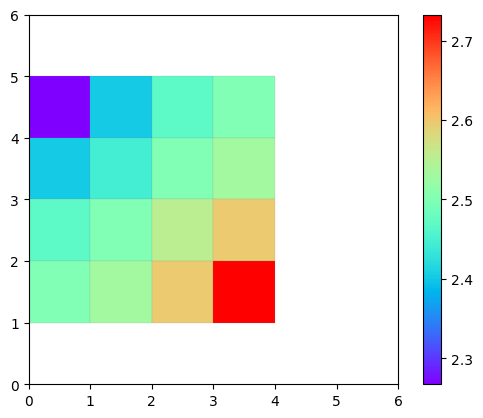

In [19]:
# small mesh 
nodes= Any[ [0. 5.],[1. 5.],[2. 5.],[3. 5.],[4. 5.],
            [0. 4.],[1. 4.],[2. 4.],[3. 4.],[4. 4.],
            [0. 3.],[1. 3.],[2. 3.],[3. 3.],[4. 3.],
            [0. 2.],[1. 2.],[2. 2.],[3. 2.],[4. 2.],
            [0. 1.],[1. 1.],[2. 1.],[3. 1.],[4. 1.] ];

elements= Any[ [1 6 7 2],[2 7 8 3],[3 8 9 4],[4 9 10 5],
               [6 11 12 7],[7 12 13 8],[8 13 14 9],[9 14 15 10],
               [11 16 17 12],[12 17 18 13],[13 18 19 14],[14 19 20 15],
               [16 21 22 17],[17 22 23 18],[18 23 24 19],[19 24 25 20] ];

# BCs nodes
DBC_nodes = Dict("1" => [1],
                 "2" => [25]);

# node set "1" is set to 2 and node set "2" is set to 3
DBC_values = Dict("1" => 2.0, "2" => 3.0);


DBC = Dict("nodes" => DBC_nodes,
           "values" => DBC_values);
ρ = 0.0
nDoF = length(nodes);

x = solve()
draw_mesh(elements, nodes,x[1:nDoF])

In [22]:
# A fine mesh (60x60)
N_x = 61
L_x = 4
nodes = [ [i j] for i in 0:(L_x/(N_x-1)):4, j in 1:(L_x/(N_x-1)):5]
elements = [[i+N_x*(j-1)      , i+1+N_x*(j-1),
             i+1+N_x+N_x*(j-1), i+N_x+N_x*(j-1)] for i in 1:(N_x-1),
                                                     j in 1:(N_x-1)]
nDoF = length(nodes);

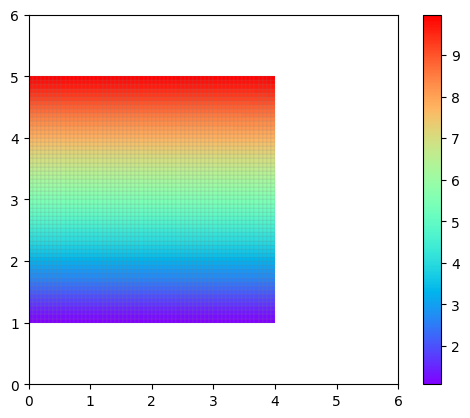

In [24]:
# BCs 2 parallel edges are prescribed, plus zero heating (ρ=0)
DBC_nodes = Dict("1" => 1:N_x,
                 "2" => N_x*(N_x-1):N_x*N_x);

DBC_values = Dict("1" => 1.0, "2" => 10.0);

DBC = Dict("nodes" => DBC_nodes,
           "values" => DBC_values);
ρ = 0.0
x = solve()
draw_mesh(elements, nodes,x[1:nDoF])

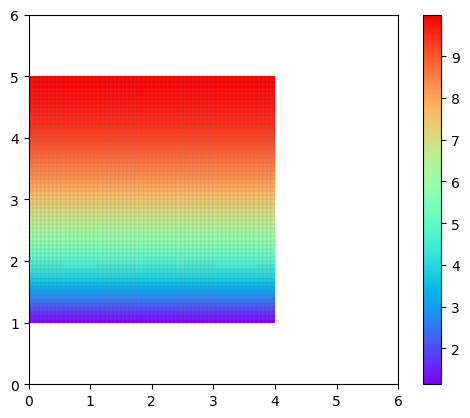

In [25]:
# BCs 2 parallel edges are prescribed, plus nonzero heating (ρ=1)
DBC_nodes = Dict("1" => 1:N_x,
                 "2" => N_x*(N_x-1):N_x*N_x);

DBC_values = Dict("1" => 1.0, "2" => 10.0);

DBC = Dict("nodes" => DBC_nodes,
           "values" => DBC_values);
ρ = 1.0
x = solve()
draw_mesh(elements, nodes,x[1:nDoF])

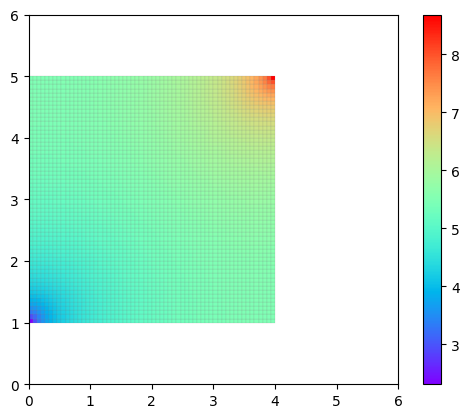

In [28]:
# BCs: 2 nodes on a diagonal are prescribed and zero heating (ρ=0)
DBC_nodes = Dict("1" => [1],
                 "2" => [N_x*N_x]);

DBC_values = Dict("1" => 1.0, "2" => 10.0);

DBC = Dict("nodes" => DBC_nodes,
           "values" => DBC_values);
ρ = 0.0
x = solve()
draw_mesh(elements, nodes,x[1:nDoF])

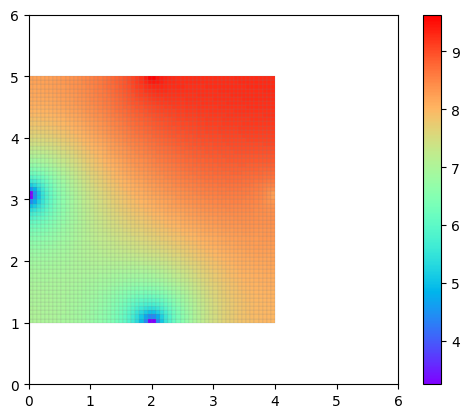

In [30]:
# BCs: 2 nodes at the center of two parallel edges are prescribed, plus small heating
DBC_nodes = Dict("1" => [31],
                 "2" => [31+(N_x-1)*N_x],
                 "3" => [1+N_x*31],
                 "4" => [N_x*32]);

DBC_values = Dict("1" => 1.0, "2" => 10.0, "3" => 1., "4" => 8.);

DBC = Dict("nodes" => DBC_nodes,
           "values" => DBC_values);
ρ = 0.5
x = solve()

draw_mesh(elements, nodes,x[1:nDoF])